In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import cv2
import numpy as np
import skimage.io as skio
import os

root_path = r'/data/sunrui/celldata/r03c06f04ch1/'
file_name = r'r03c06f04ch1.tif'

# 读取一系列图像
raw_path = root_path + '/01_GT/SEG/'  # 原始图像路径
imgfiles = [os.path.join(raw_path, f) for f in os.listdir(raw_path) if f.endswith('.tif') or f.endswith('.tiff')]
imgfiles.sort()

img_seg = []

print(len(imgfiles))
for i in range(len(imgfiles)):
    img_seg.append(skio.imread(imgfiles[i]).astype(np.uint16))
print(len(img_seg))
img_seg = np.array(img_seg)
print(img_seg.shape)

#读取原始图像
raw_path = root_path + r'/01/'#原始图像路径
imgfiles = [os.path.join(raw_path, f) for f in os.listdir(raw_path) if f.endswith('.tif') or f.endswith('.tiff')]
imgfiles.sort()

img_raw = []
print(len(imgfiles))
for i in range(len(imgfiles)):
    img_raw.append(skio.imread(imgfiles[i]).astype(np.uint16))
print(len(img_raw))
img_raw = np.array(img_raw)
img_raw = np.expand_dims(img_raw, axis=3)
# img_raw = img_raw.squeeze()
print(img_raw.shape)


329
329
(329, 1080, 1080, 1)
329
329
(329, 1080, 1080, 1)


In [2]:
import os
import os.path as op

from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import cv2
from skimage import io
from skimage.measure import regionprops
import warnings
warnings.filterwarnings("always")

# from src_metric_learning.modules.resnet_2d.resnet import set_model_architecture, MLP
from skimage.morphology import label

/home/sunrui/anaconda3/envs/cell-tracking-challenge/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1080, 1080, 1)
1166400


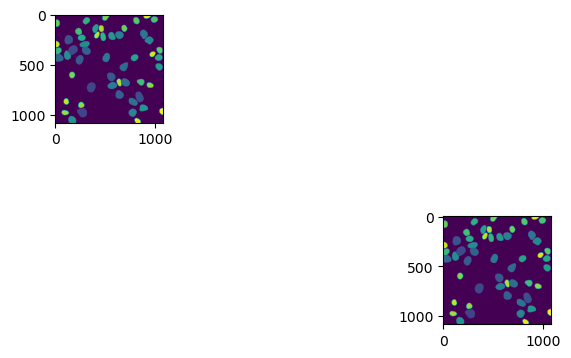

In [3]:

min_cell_size = 20
result = img_seg[0]
img = img_raw[0]

res_save = result.copy()
labels_mask = result.copy()

print(result.shape)
print(result.size)
per_cell_change = False
per_mask_change = False

import matplotlib.pyplot as plt
plt.subplot(2,4,1)
plt.imshow(result)
plt.subplot(2,4,8)
plt.imshow(labels_mask)
plt.show()

In [4]:
# for ind, id_res in enumerate(np.unique(result)):
#     if id_res == 0:
#         continue
#     bin_mask = (result == id_res).copy()
#     plt.figure(figsize=(20,20))
#     plt.subplot(2,4,1)
#     plt.imshow(bin_mask)
#     plt.show()
#     print(np.count_nonzero(bin_mask))

In [5]:

# n_changes = 0
# for ind, id_res in enumerate(np.unique(result)):
#     plt.subplot(2,4,1)
#     print('1')
#     plt.imshow(result)
#     if id_res == 0:
#         continue
#     bin_mask = (result == id_res).copy()
#     plt.subplot(2,4,2)
#     print('2')
#     plt.imshow(bin_mask)
#     print(id_res)
#     while True:
#         re_label_mask = label(bin_mask)
#         plt.subplot(2,4,3)
#         print('3')
#         plt.imshow(re_label_mask)
#         un_labels, counts = np.unique(re_label_mask, return_counts=True)
#         print('counts1:', counts)
#         print('un_labels1:', un_labels)

#         if np.any(counts < min_cell_size):
#             per_cell_change = True

#             first_label_ind = np.argwhere(counts < min_cell_size)
#             if first_label_ind.size > 1:
#                 first_label_ind = first_label_ind.squeeze()[0]
#             first_label_num = un_labels[first_label_ind]
#             curr_mask = np.logical_and(result == id_res, re_label_mask == first_label_num)
#             bin_mask[curr_mask] = False
#             result[curr_mask] = 0.0
#         else:
#             break
#     while True:
#         re_label_mask = label(bin_mask)
#         plt.subplot(2,4,4)
#         print('4')
#         plt.imshow(re_label_mask)
#         un_labels, counts = np.unique(re_label_mask, return_counts=True)
#         print('counts2:', counts)
#         print('un_labels2:', un_labels)
#         if un_labels.shape[0] > 2:
#             print(un_labels.shape[0])
#             per_cell_change = True
#             n_changes += 1
#             first_label_ind = np.argmin(counts)
#             print('first_label_ind:', first_label_ind)
#             if first_label_ind.size > 1:
#                 first_label_ind = first_label_ind.squeeze()[0]
#                 print('first_label_ind squeeze:', first_label_ind)
#             first_label_num = un_labels[first_label_ind]

#             curr_mask = np.logical_and(result == id_res, re_label_mask == first_label_num)
#             plt.subplot(2,4,5)
#             print('5')
#             plt.imshow(curr_mask)
#             bin_mask[curr_mask] = False
#             plt.subplot(2,4,6)
#             print('6')
#             plt.imshow(bin_mask)
#             result[curr_mask] = 0.0
#             plt.subplot(2,4,7)
#             print('7')
#             plt.imshow(result)
#             # plt.show()
#         else:
#             # plt.show()
#             break
#     plt.show()
# if not np.all(np.unique(result) == np.unique(res_save)):
#     print(f'pay attention! the labels have changed from {np.unique(res_save)} to {np.unique(result)}')
#     # warnings.warn(
#     #     f"pay attention! the labels have changed from {np.unique(res_save)} to {np.unique(result)}")
# if per_cell_change or per_mask_change:
#     n_changes += 1
#     res1 = (res_save > 0) * 1.0
#     res2 = (result > 0) * 1.0
#     n_pixels = np.abs(res1 - res2).sum()
#     print(f"per_mask_change={per_mask_change}, per_cell_change={per_cell_change}, number of changed pixels: {n_pixels}")
#     # io.imsave("/data/sunrui/celldata/r03c03f01/01_GT/postresult/", result.astype(np.uint16), compress=6)


In [6]:
dict_path = '/home/sunrui/cellwork/track/cell-tracker-gnn-main/outputs/2023-07-06/19-57-00/all_params.pth'

dict_params = torch.load(dict_path)

In [7]:
print(result.shape)
print(img.shape)
result = np.squeeze(result)
img = np.squeeze(img)

(1080, 1080, 1)
(1080, 1080, 1)


In [8]:
# print(dict_params)
roi_model = dict_params['roi']

global_min = 2 ** 16 - 1
global_max = 0
global_delta_row = 0
global_delta_col = 0
counter = 0

for ind, id_res in enumerate(np.unique(result)):
    if id_res == 0:
        continue

    properties = regionprops(np.uint8(result == id_res), img)[0]
    # print(properties.bbox)
    min_row_bb, min_col_bb, max_row_bb, max_col_bb = properties.bbox
    delta_row = np.abs(max_row_bb - min_row_bb)
    delta_col = np.abs(max_col_bb - min_col_bb)

    if (delta_row > roi_model['row']) or (delta_col > roi_model['col']):
        counter += 1

    global_delta_row = max(global_delta_row, delta_row)
    global_delta_col = max(global_delta_col, delta_col)

res_bin = result != 0
try:
    # 执行操作
    min_curr = result[res_bin].min()
    max_curr = result[res_bin].max()
except ValueError as e:
    # 处理空图像的情况
    print("Empty image detected. Error:", e)
    # continue  # 跳过当前图像

lobal_min = min(global_min, min_curr)
global_max = max(global_max, max_curr)
print(f"lobal_min: {lobal_min}")
print(f"global_max: {global_max}")
print(counter)
print(f"global_delta_row: {global_delta_row}")
print(f"global_delta_col: {global_delta_col}")
print('roi_model_row:', roi_model['row'])
print('roi_model_col:', roi_model['col'])
min_cell = global_min
max_cell = global_max
flag_new_roi = global_delta_row > roi_model['row'] or global_delta_col > roi_model['col']
if flag_new_roi:
    global_delta_row = max(global_delta_row,roi_model['row'])
    global_delta_col = max(global_delta_col,roi_model['col'])
    print("Assign new region of interest")
    print(f"old ROI: {roi_model}, new: row: {global_delta_row}, col : {global_delta_col}")
else:
    print("We don't assign new region of interest - use the old one")




lobal_min: 13
global_max: 65
0
global_delta_row: 106
global_delta_col: 100
roi_model_row: 116
roi_model_col: 119
We don't assign new region of interest - use the old one


In [9]:
from src_metric_learning.modules.resnet_2d.resnet import set_model_architecture, MLP


# models params
pad_value = dict_params['pad_value']
print(f'pad_value:{pad_value}')
model_name = dict_params['model_name']
print(f'model_name:{model_name}')
mlp_dims = dict_params['mlp_dims']
print(f'mlp_dims:{mlp_dims}')
mlp_normalized_features = dict_params['mlp_normalized_features']
# models state_dict
trunk_state_dict = dict_params['trunk_state_dict']
embedder_state_dict = dict_params['embedder_state_dict']

trunk = set_model_architecture(model_name)
trunk.load_state_dict(trunk_state_dict)
print (trunk)
trunk.eval()

embedder = MLP(mlp_dims, normalized_feat=mlp_normalized_features)
embedder.load_state_dict(embedder_state_dict)
print(embedder)
embedder.eval()

cols = ["seg_label",
        "frame_num",
        "area",
        "min_row_bb", "min_col_bb", "max_row_bb", "max_col_bb",
        "centroid_row", "centroid_col",
        "major_axis_length", "minor_axis_length",
        "max_intensity", "mean_intensity", "min_intensity"
        ]

cols_resnet = [f'feat_{i}' for i in range(mlp_dims[-1])]
cols += cols_resnet



pad_value:0
model_name:resnet18
mlp_dims:[512, 128]
Using resnet18 model architecture.
Resnet18Triplet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [10]:
def padding(img):
    if flag_new_roi:
        desired_size_row = global_delta_row
        desired_size_col = global_delta_col
    else:
        desired_size_row = roi_model['row']
        desired_size_col = roi_model['col']
    delta_row = desired_size_row - img.shape[0]
    delta_col = desired_size_col - img.shape[1]
    pad_top = delta_row // 2
    pad_left = delta_col // 2

    image = cv2.copyMakeBorder(img, pad_top, delta_row - pad_top, pad_left, delta_col - pad_left,
                                cv2.BORDER_CONSTANT, value=pad_value)

    if flag_new_roi:
        image = cv2.resize(image, dsize=(roi_model['col'], roi_model['row']))

    return image

In [11]:
def extract_freature_metric_learning(bbox, img, seg_mask, ind, normalize_type='MinMaxCell'):
    min_row_bb, min_col_bb, max_row_bb, max_col_bb = bbox
    img_patch = img[min_row_bb:max_row_bb, min_col_bb:max_col_bb]
    msk_patch = seg_mask[min_row_bb:max_row_bb, min_col_bb:max_col_bb] != ind
    img_patch[msk_patch] = pad_value
    img_patch = img_patch.astype(np.float32)

    if normalize_type == 'regular':
        img = padding(img_patch) / max_cell
    elif normalize_type == 'MinMaxCell':
        not_msk_patch = np.logical_not(msk_patch)
        img_patch[not_msk_patch] = (img_patch[not_msk_patch] - min_cell) / (max_cell - min_cell)
        img = padding(img_patch)
    else:
        assert False, "Not supported this type of normalization"

    img = torch.from_numpy(img).float()
    with torch.no_grad():
        embedded_img = embedder(trunk(img[None, None, ...]))

    return embedded_img.numpy().squeeze()



In [13]:
num_labels = np.unique(result).shape[0] - 1
df = pd.DataFrame(index=range(num_labels), columns=cols)
# print(df)


im_num = 0
for ind, id_res in enumerate(np.unique(result)):
    # Color 0 is assumed to be background or artifacts
    row_ind = ind - 1
    if id_res == 0:
        continue

    # extracting statistics using regionprops
    properties = regionprops(np.uint8(result == id_res), img)[0]

    embedded_feat = extract_freature_metric_learning(properties.bbox, img.copy(), result.copy(), id_res)
    df.loc[row_ind, cols_resnet] = embedded_feat
    df.loc[row_ind, "seg_label"] = id_res

    df.loc[row_ind, "area"] = properties.area

    df.loc[row_ind, "min_row_bb"], df.loc[row_ind, "min_col_bb"], \
    df.loc[row_ind, "max_row_bb"], df.loc[row_ind, "max_col_bb"] = properties.bbox

    df.loc[row_ind, "centroid_row"], df.loc[row_ind, "centroid_col"] = \
        properties.centroid[0].round().astype(np.int16), \
        properties.centroid[1].round().astype(np.int16)

    df.loc[row_ind, "major_axis_length"], df.loc[row_ind, "minor_axis_length"] = \
        properties.major_axis_length, properties.minor_axis_length

    df.loc[row_ind, "max_intensity"], df.loc[row_ind, "mean_intensity"], df.loc[row_ind, "min_intensity"] = \
        properties.max_intensity, properties.mean_intensity, properties.min_intensity
df.loc[:, "frame_num"] = int(im_num)
if df.isnull().values.any():
    warnings.warn("Pay Attention! there are Nan values!")

# print(df)


   seg_label  frame_num  area min_row_bb min_col_bb max_row_bb max_col_bb  \
0         13          0  6868        933        220       1023        320   
1         14          0  6855        674        318        774        406   
2         15          0  6568        303        133        400        227   
3         16          0  6489        766        805        872        887   
4         17          0  6009        202         96        293        179   
5         18          0  5506        576        521        661        604   
6         19          0  5460        401        208        495        285   
7         20          0  5415        752        606        837        687   
8         21          0  5357        317        270        397        356   
9         22          0  5295        391          0        465         84   
10        23          0  5229        474        646        562        730   
11        24          0  5223        633        664        714        748   

In [11]:

# class TestDataset(Dataset):
#     """Example dataset class for loading images from folder."""

#     def __init__(self,
#                  path: str,
#                  path_result: str,

#                  type_img: str,
#                  type_masks: str
#                  ):

#         self.path = path

#         self.path_result = path_result

#         dir_img = path
#         dir_results = path_result

#         self.images = []
#         if os.path.exists(dir_img):
#             self.images = [os.path.join(dir_img, fname) for fname in sorted(os.listdir(dir_img))
#                            if type_img in fname]

#         self.results = []
#         if os.path.exists(dir_results):
#             self.results = [os.path.join(dir_results, fname) for fname in sorted(os.listdir(dir_results))
#                             if type_masks in fname]

#     def __getitem__(self, idx):
#         assert len(self.images) or len(self.images), "both directories are empty, please fix it!"

#         im_path, image = None, None
#         if len(self.images):
#             im_path = self.images[idx]
#             image = np.array(Image.open(im_path))

#         result_path, result = None, None
#         if len(self.results):
#             result_path = self.results[idx]
#             result = np.array(Image.open(result_path))
#         flag = True
#         if im_path is not None:
#             flag = False
#             im_num = im_path.split(".")[-2][-3:]

#         if result_path is not None:
#             flag = False
#             result_num = result_path.split(".")[-2][-3:]

#         if flag:
#             assert im_num == result_num, f"Image number ({im_num}) is not equal to result number ({result_num})"

#         return image, result, im_path, result_path

#     def __len__(self):
#         return len(self.images)

#     def padding(self, img):
#         if self.flag_new_roi:
#             desired_size_row = self.global_delta_row
#             desired_size_col = self.global_delta_col
#         else:
#             desired_size_row = self.roi_model['row']
#             desired_size_col = self.roi_model['col']
#         delta_row = desired_size_row - img.shape[0]
#         delta_col = desired_size_col - img.shape[1]
#         pad_top = delta_row // 2
#         pad_left = delta_col // 2

#         image = cv2.copyMakeBorder(img, pad_top, delta_row - pad_top, pad_left, delta_col - pad_left,
#                                    cv2.BORDER_CONSTANT, value=self.pad_value)

#         if self.flag_new_roi:
#             image = cv2.resize(image, dsize=(self.roi_model['col'], self.roi_model['row']))

#         return image

#     def extract_freature_metric_learning(self, bbox, img, seg_mask, ind, normalize_type='MinMaxCell'):
#         min_row_bb, min_col_bb, max_row_bb, max_col_bb = bbox
#         img_patch = img[min_row_bb:max_row_bb, min_col_bb:max_col_bb]
#         msk_patch = seg_mask[min_row_bb:max_row_bb, min_col_bb:max_col_bb] != ind
#         img_patch[msk_patch] = self.pad_value
#         img_patch = img_patch.astype(np.float32)

#         if normalize_type == 'regular':
#             img = self.padding(img_patch) / self.max_img
#         elif normalize_type == 'MinMaxCell':
#             not_msk_patch = np.logical_not(msk_patch)
#             img_patch[not_msk_patch] = (img_patch[not_msk_patch] - self.min_cell) / (self.max_cell - self.min_cell)
#             img = self.padding(img_patch)
#         else:
#             assert False, "Not supported this type of normalization"

#         img = torch.from_numpy(img).float()
#         with torch.no_grad():
#             embedded_img = self.embedder(self.trunk(img[None, None, ...]))

#         return embedded_img.numpy().squeeze()

#     def correct_masks(self, min_cell_size):
#         n_changes = 0
#         for ind_data in range(self.__len__()):
#             per_cell_change = False
#             per_mask_change = False

#             img, result, im_path, result_path = self[ind_data]
#             print(img.shape)
#             print(result.shape)
            
#             res_save = result.copy()
#             labels_mask = result.copy()

#             #去除小于min_cell_size的细胞mask
#             # 这个while循环会重复进行以下操作：将结果掩膜中小于min_cell_size的细胞掩膜标记为0。
#             # labels_mask是一个临时变量，用于保存标记操作后的结果掩膜。bin_mask是结果掩膜中非零像素的二值掩膜。
#             # 通过label()函数对二值掩膜进行标记，然后计算每个标记的像素数量。
#             # 如果存在像素数量小于min_cell_size的标记，就将这些标记对应的像素值设置为0。

#             while True:
#                 bin_mask = labels_mask > 0
#                 re_label_mask = label(bin_mask)
#                 un_labels, counts = np.unique(re_label_mask, return_counts=True)

#                 if np.any(counts < min_cell_size):
#                     per_mask_change = True

#                     first_label_ind = np.argwhere(counts < min_cell_size)
#                     if first_label_ind.size > 1:
#                         first_label_ind = first_label_ind.squeeze()[0]
#                     first_label_num = un_labels[first_label_ind]
#                     labels_mask[re_label_mask == first_label_num] = 0
#                 else:
#                     break
#             bin_mask = (labels_mask > 0) * 1.0
#             result = np.multiply(result, bin_mask)
#             if not np.all(np.unique(result) == np.unique(res_save)):
#                 print(f'pay attention! the labels have changed from {np.unique(res_save)} to {np.unique(result)}')
#                 warnings.warn(
#                     f"pay attention! the labels have changed from {np.unique(res_save)} to {np.unique(result)}")

#             #这个while循环会重复进行以下操作：将结果掩膜中小于min_cell_size的细胞掩膜标记为0。
#             # labels_mask是一个临时变量，用于保存标记操作后的结果掩膜。bin_mask是结果掩膜中非零像素的二值掩膜。
#             # 通过label()函数对二值掩膜进行标记，然后计算每个标记的像素数量。
#             # 如果存在像素数量小于min_cell_size的标记，就将这些标记对应的像素值设置为0。

#             for ind, id_res in enumerate(np.unique(result)):
#                 if id_res == 0:
#                     continue
#                 bin_mask = (result == id_res).copy()
#                 while True:
#                     re_label_mask = label(bin_mask)
#                     un_labels, counts = np.unique(re_label_mask, return_counts=True)

#                     if np.any(counts < min_cell_size):
#                         per_cell_change = True

#                         first_label_ind = np.argwhere(counts < min_cell_size)
#                         if first_label_ind.size > 1:
#                             first_label_ind = first_label_ind.squeeze()[0]
#                         first_label_num = un_labels[first_label_ind]
#                         curr_mask = np.logical_and(result == id_res, re_label_mask == first_label_num)
#                         bin_mask[curr_mask] = False
#                         result[curr_mask] = 0.0
#                     else:
#                         break
#                 while True:
#                     re_label_mask = label(bin_mask)
#                     un_labels, counts = np.unique(re_label_mask, return_counts=True)
#                     if un_labels.shape[0] > 2:
#                         per_cell_change = True
#                         n_changes += 1
#                         first_label_ind = np.argmin(counts)
#                         if first_label_ind.size > 1:
#                             first_label_ind = first_label_ind.squeeze()[0]
#                         first_label_num = un_labels[first_label_ind]
#                         curr_mask = np.logical_and(result == id_res, re_label_mask == first_label_num)
#                         bin_mask[curr_mask] = False
#                         result[curr_mask] = 0.0
#                     else:
#                         break
#             if not np.all(np.unique(result) == np.unique(res_save)):
#                 print(f'pay attention! the labels have changed from {np.unique(res_save)} to {np.unique(result)}')
#                 warnings.warn(
#                     f"pay attention! the labels have changed from {np.unique(res_save)} to {np.unique(result)}")
#             if per_cell_change or per_mask_change:
#                 n_changes += 1
#                 res1 = (res_save > 0) * 1.0
#                 res2 = (result > 0) * 1.0
#                 n_pixels = np.abs(res1 - res2).sum()
#                 print(f"per_mask_change={per_mask_change}, per_cell_change={per_cell_change}, number of changed pixels: {n_pixels}")
#                 # io.imsave("/data/sunrui/celldata/r03c03f01/01_GT/postresult/", result.astype(np.uint16), compress=6)



#         print(f"number of detected changes: {n_changes}")


#     def find_min_max_and_roi(self):
#         global_min = 2 ** 16 - 1
#         global_max = 0
#         global_delta_row = 0
#         global_delta_col = 0
#         counter = 0
#         for ind_data in range(self.__len__()):
#             img, result, im_path, result_path = self[ind_data]

#             for ind, id_res in enumerate(np.unique(result)):
#                 if id_res == 0:
#                     continue

#                 properties = regionprops(np.uint8(result == id_res), img)[0]
#                 min_row_bb, min_col_bb, max_row_bb, max_col_bb = properties.bbox
#                 delta_row = np.abs(max_row_bb - min_row_bb)
#                 delta_col = np.abs(max_col_bb - min_col_bb)

#                 if (delta_row > self.roi_model['row']) or (delta_col > self.roi_model['col']):
#                     counter += 1

#                 global_delta_row = max(global_delta_row, delta_row)
#                 global_delta_col = max(global_delta_col, delta_col)

#             res_bin = result != 0
#             min_curr = img[res_bin].min()
#             max_curr = img[res_bin].max()

#             global_min = min(global_min, min_curr)
#             global_max = max(global_max, max_curr)
#         print(counter)
#         print(f"global_delta_row: {global_delta_row}")
#         print(f"global_delta_col: {global_delta_col}")
#         self.min_cell = global_min
#         self.max_cell = global_max

#         self.global_delta_row = global_delta_row
#         self.global_delta_col = global_delta_col

#     # def preprocess_features_loop_by_results_w_metric_learning(self, path_to_write, dict_path):
#     #     dict_params = torch.load(dict_path)

#     #     self.roi_model = dict_params['roi']
#     #     self.find_min_max_and_roi()
#     #     self.flag_new_roi = self.global_delta_row > self.roi_model['row'] or self.global_delta_col > self.roi_model['col']
#     #     if self.flag_new_roi:
#     #         self.global_delta_row = max(self.global_delta_row, self.roi_model['row'])
#     #         self.global_delta_col = max(self.global_delta_col, self.roi_model['col'])
#     #         print("Assign new region of interest")
#     #         print(f"old ROI: {self.roi_model}, new: row: {self.global_delta_row}, col : {self.global_delta_col}")
#     #     else:
#     #         print("We don't assign new region of interest - use the old one")

#     #     self.pad_value = dict_params['pad_value']
#     #     # models params
#     #     model_name = dict_params['model_name']
#     #     mlp_dims = dict_params['mlp_dims']
#     #     mlp_normalized_features = dict_params['mlp_normalized_features']
#     #     # models state_dict
#     #     trunk_state_dict = dict_params['trunk_state_dict']
#     #     embedder_state_dict = dict_params['embedder_state_dict']

#     #     trunk = set_model_architecture(model_name)
#     #     trunk.load_state_dict(trunk_state_dict)
#     #     self.trunk = trunk
#     #     self.trunk.eval()

#     #     embedder = MLP(mlp_dims, normalized_feat=mlp_normalized_features)
#     #     embedder.load_state_dict(embedder_state_dict)
#     #     self.embedder = embedder
#     #     self.embedder.eval()

#     #     cols = ["seg_label",
#     #             "frame_num",
#     #             "area",
#     #             "min_row_bb", "min_col_bb", "max_row_bb", "max_col_bb",
#     #             "centroid_row", "centroid_col",
#     #             "major_axis_length", "minor_axis_length",
#     #             "max_intensity", "mean_intensity", "min_intensity"
#     #             ]


#     #     cols_resnet = [f'feat_{i}' for i in range(mlp_dims[-1])]
#     #     cols += cols_resnet

#     #     for ind_data in range(self.__len__()):
#     #         img, result, im_path, result_path = self[ind_data]

#     #         im_num = im_path.split(".")[-2][-3:]
#     #         result_num = result_path.split(".")[-2][-3:]
#     #         assert im_num == result_num, f"Image number ({im_num}) is not equal to result number ({result_num})"

#     #         num_labels = np.unique(result).shape[0] - 1

#     #         df = pd.DataFrame(index=range(num_labels), columns=cols)

#     #         for ind, id_res in enumerate(np.unique(result)):
#     #             # Color 0 is assumed to be background or artifacts
#     #             row_ind = ind - 1
#     #             if id_res == 0:
#     #                 continue

#     #             # extracting statistics using regionprops
#     #             properties = regionprops(np.uint8(result == id_res), img)[0]

#     #             embedded_feat = self.extract_freature_metric_learning(properties.bbox, img.copy(), result.copy(), id_res)
#     #             df.loc[row_ind, cols_resnet] = embedded_feat
#     #             df.loc[row_ind, "seg_label"] = id_res

#     #             df.loc[row_ind, "area"] = properties.area

#     #             df.loc[row_ind, "min_row_bb"], df.loc[row_ind, "min_col_bb"], \
#     #             df.loc[row_ind, "max_row_bb"], df.loc[row_ind, "max_col_bb"] = properties.bbox

#     #             df.loc[row_ind, "centroid_row"], df.loc[row_ind, "centroid_col"] = \
#     #                 properties.centroid[0].round().astype(np.int16), \
#     #                 properties.centroid[1].round().astype(np.int16)

#     #             df.loc[row_ind, "major_axis_length"], df.loc[row_ind, "minor_axis_length"] = \
#     #                 properties.major_axis_length, properties.minor_axis_length

#     #             df.loc[row_ind, "max_intensity"], df.loc[row_ind, "mean_intensity"], df.loc[row_ind, "min_intensity"] = \
#     #                 properties.max_intensity, properties.mean_intensity, properties.min_intensity


#     #         df.loc[:, "frame_num"] = int(im_num)

#     #         if df.isnull().values.any():
#     #             warnings.warn("Pay Attention! there are Nan values!")

#     #         full_dir = op.join(path_to_write, "csv")
#     #         os.makedirs(full_dir, exist_ok=True)
#     #         file_path = op.join(full_dir, f"frame_{im_num}.csv")
#     #         df.to_csv(file_path, index=False)
#     #     print(f"files were saved to : {full_dir}")


In [12]:
# def create_csv(input_images, input_seg, input_model, output_csv, min_cell_size):
#     dict_path = input_model
#     path_output = output_csv
#     path_Seg_result = input_seg
#     ds = TestDataset(
#         path=input_images,
#         path_result=path_Seg_result,
#         type_img="tif",
#         type_masks="tif")
#     ds.correct_masks(min_cell_size)
#     # ds.preprocess_features_loop_by_results_w_metric_learning(path_to_write=path_output,
#     #     dict_path=dict_path)

In [13]:
# path = r'/data/sunrui/celldata/r03c03f01/01/'

# path_result = r'/data/sunrui/celldata/r03c03f01/01_GT/SEG/'


# min_cell_size = 20
# input_images = path
# input_segmentation = path_result
# input_model = r"/home/sunrui/cellwork/track/cell-tracker-gnn-main/outputs/2023-05-24/09-29-19/all_params.pth"

# output_csv = r'/data/sunrui/celldata/r03c03f01/01_CSV/'

# create_csv(input_images, input_segmentation, input_model, output_csv, min_cell_size)
